# Exploring the Data (images)

In [1]:
!pip install tesserocr
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-eng
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.3 MB/s eta 0:00:00:00:010:01
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,185 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://security

In [2]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import pytesseract
from tesserocr import PyTessBaseAPI
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm.notebook import tqdm

In [3]:
# Data loading

base_path = "/kaggle/input/rvl-cdip-small"
print(f"Files: {os.listdir(base_path)} \n")

data_path = "/kaggle/input/rvl-cdip-small/data"
data_path = Path(data_path)

print(f"Files: {os.listdir(data_path)} \n")

file_paths = list(data_path.glob('**/*.tif'))

print(f"Total files found: {len(file_paths)}")

Files: ['data'] 

Files: ['resume', 'memo', 'scientific publication', 'news article', 'specification', 'letter', 'form', 'budget', 'handwritten', 'file folder', 'email', 'scientific report', 'invoice', 'presentation', 'questionnaire', 'advertisement'] 

Total files found: 47996


sample_img_path: /kaggle/input/rvl-cdip-small/data/resume/50547319-7320.tif


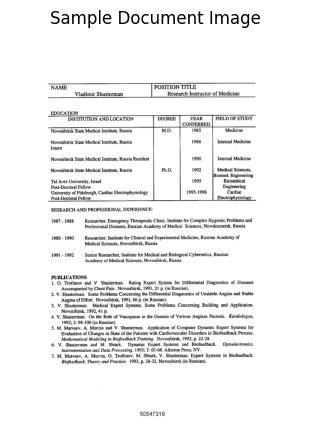

In [4]:
file_paths = [str(f) for f in file_paths]

# Displaying a Sample Image 
img_path = file_paths[1]
print(f"sample_img_path: {img_path}")

# Check once
if os.path.isfile(img_path):
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sample Document Image", fontsize=12)
    plt.show()
else:
    print(f"Image not found at: {img_path}")

# Data Preprocessing

## Optical Character Recognition (OCR)

In [5]:
# Tesseract function for OCR

def extracting_text_tesserocr(img_path, lang='eng', psm=3):
    img = Image.open(img_path)
    tessdata_path = "/usr/share/tesseract-ocr/4.00/tessdata"

    with PyTessBaseAPI(lang=lang, psm=psm, path=tessdata_path) as api:
        api.SetImage(img)
        text = api.GetUTF8Text()
    return text

In [ ]:
# Using Tesseract on 10k samples (only 10k due to time constrains)
sample_images = random.sample(file_paths, k=10000)

# Storing General Info of Images:
image_ids = [((f.split('/')[-1]).replace('.tif', '')).split('-')[0] for f in sample_images]
classes = [((f.split('/')[-2])) for f in sample_images]
unique_classes = set(classes)
 
extracted_texts = []
for img_path in tqdm(sample_images):
    text = extracting_text_tesserocr(img_path)
    extracted_texts.append(text)

# Creating an DataFrame
df_info = pd.DataFrame({'Extracted Texts': extracted_texts, 'Image Paths': sample_images, 'Image Ids': image_ids, 'Class': classes})
df.to_csv('ocr_dataset(1)', index=False)

In [7]:
# df_info.to_csv('/kaggle/working/myfile.csv', index=False)

df_info = pd.read_csv('/kaggle/input/ocr-dataset/ocr_dataset(new)')
df_info['Extracted Texts'] = df_info['Extracted Texts'].fillna("").astype(str)
extracted_texts = df_info['Extracted Texts'].tolist()

In [10]:
# More features for final DataFrame

import numpy as np
import re
import cv2
from PIL import Image

aspect_ratios = []
avg_line_lengths = []
words_count = []
text_densities = []

for img_text in extracted_texts:
    
    # words count 
    words = re.findall(r"\b\w+\b", img_text.lower())
    count = len(words)
    words_count.append(count)

    # average line length
    lines = [l for l in img_text.split('\n') if l.strip()]

    if len(lines) == 0:
        avg_line_lengths.append(0)  
        continue
         
    avg_line_length = sum(len(l) for l in lines) / len(lines)
    avg_line_lengths.append(avg_line_length)


for img_path in sample_images:
    
     # image aspect ratios
    img = Image.open(img_path)
    width, height = img.size
    ratio = height / width
    aspect_ratios.append(ratio)

    # text density
    img.convert('L')
    img = np.array(img)
    _, th = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)
    density = th.mean()
    text_densities.append(density)


## Data Cleaning and SBERT

In [11]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = ' '.join(text.split())
    return text.lower()

cleaned_texts = [clean_text(text) for text in df_info['Extracted Texts']] 

In [22]:
# SBERT SHIT
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = encoder.encode(cleaned_texts, batch_size=32, show_progress_bar=True)
df = pd.DataFrame(embeddings, index=df_info.index)

df['TextDensity'] = text_densities
df['AspectRatio'] = aspect_ratios
df['Avg_line_lengths'] = avg_line_lengths
df['Word_counts'] = words_count
df['Class'] = df_info['Class']

In [13]:
set(df_info['Class'])

{'advertisement',
 'budget',
 'email',
 'file folder',
 'form',
 'handwritten',
 'invoice',
 'letter',
 'memo',
 'news article',
 'presentation',
 'questionnaire',
 'resume',
 'scientific publication',
 'scientific report',
 'specification'}

In [14]:
mapping = {
    "letter": "business_correspondence",
    "email": "business_correspondence",
    "memo": "business_correspondence",
    "handwritten": "business_correspondence",

    "form": "forms",
    "questionnaire": "forms",

    "invoice": "financial",
    "budget": "financial",

    "scientific publication": "technical",
    "scientific report": "technical",
    "specification": "technical",
    "presentation": "technical",

    "resume": "other",
    "file folder": "other",
    "advertisement": "other",
    "news article": "other"
}

df["Class"] = df["Class"].map(mapping)

df.columns = df.columns.astype(str)

<Axes: xlabel='Class', ylabel='count'>

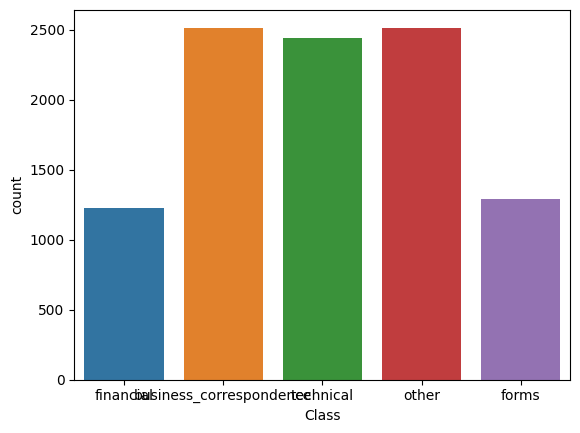

In [15]:
# Distribution of Labels (classes)
sns.countplot(data=df, x='Class')

In [16]:
# independent and dependent features and spliting
from sklearn.model_selection import train_test_split
y = df['Class']
x = df.drop('Class', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
# label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [18]:
# Scaling down the SBERT features and meta_features scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# Model Training

In [21]:
# finding the best_model

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

models = {
    'logisticReg': LogisticRegression(max_iter=1000),
    'linearSVC': LinearSVC(max_iter=1000),
    'lightGBM': LGBMClassifier(),
    'Xgboost': XGBClassifier()
}

n_model = len(models)

# Evals_metrics
eval_metrics = {'Model': [], 'Accuracy Test': []}

for i, (model_name, model) in tqdm(enumerate(models.items())):

    # Cross Validation -> Skipped (computationally expensive)
    
    # fitting the model
    model.fit(x_train, y_train)
    
    # prediction
    y_pred = model.predict(x_test)
    accuracy_test = accuracy_score(y_test, y_pred)

    # Storing the evalutions
    eval_metrics['Model'].append(model_name)
    eval_metrics['Accuracy Test'].append(accuracy_test)

eval_metrics = pd.DataFrame(eval_metrics)

In [ ]:
eval_metrics.sort_values(by='Accuracy Test')

# Hyperparam Optimization

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.2),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        
        # simplified regularization
        "gamma": trial.suggest_float("gamma", 0, 2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),

        # CPU settings
        # "tree_method": "hist",
        "eval_metric": "mlogloss",
        "n_jobs": -1
    }

    model = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"Best CV Accuracy: {study.best_value}")
print(f"Best Params: {study.best_params}")

In [ ]:
best_params = study.best_params
best_params.update({
    "tree_method": "hist",
    "eval_metric": "mlogloss",
    "n_jobs": -1
})

# feeding the best params
final_model = XGBClassifier(**best_params)
final_model.fit(x_train, y_train)

# prediction
y_pred = final_model.predict(x_test)
accuracy_test = accuracy_score(y_test, y_pred)

# evaluations
print(f"report: {classification_report(y_test, y_pred)}")
print(f"accuracy: {accuracy_test} \n")

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=final_model.classes_)
cmd.plot(cmap='Blues')

### Model Performance Report

| Class | Precision | Recall | F1-score | Support |
|------:|----------:|-------:|---------:|--------:|
| 0 | 0.69 | 0.75 | 0.72 | 526 |
| 1 | 0.79 | 0.73 | 0.76 | 246 |
| 2 | 0.78 | 0.57 | 0.66 | 268 |
| 3 | 0.74 | 0.84 | 0.79 | 477 |
| 4 | 0.74 | 0.72 | 0.73 | 483 |
| **Accuracy** |  |  | **0.74** | **2000** |
| **Macro Avg** | **0.75** | **0.72** | **0.73** | **2000** |
| **Weighted Avg** | **0.74** | **0.74** | **0.74** | **2000** |

**Overall Accuracy:** `0.737`


![](https://www.kaggleusercontent.com/kf/285833976/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..OWK1EJbZnYCumHaJ8avI5A.g6ZadenoQSa2sXLxOamgLONB4CImzpVj40jiIxag1-QJftGGAHQY1fZbuOcFohsNgU_JKdHa2WIW2aXgiwGGkGRaAgzC9opRVwJX8QjN_xU5Xv_nEuWiX4OIh0roxoOAtzGK1oLrM_4H2UGjlWKt2RfUoLcO9O21oB5tIAZidOiO8Wh7cZN4KZDpGNyrmQap_S9pIptph5Wia4oC8vj3Z-bIm6PlbCaUzlD1bfwVCJaTBZHdrcqojeCwzKM7CqCGDNxP-zJ4SX7isaIxcQK9jRQJfU7j1U0sJXcpyot9Xo0IJix5BXTf1sHDy2hl7xRONtI3njZVu4Lko8BW7FvqPAumHAZuQaqdJT-rvX84BjXWoQ0eASsiTHc3cjzw_1p52doWcPbtFlJRgdlcvJVM5nmXgmB0Mj0u2jxcYmoDouVmx8c0CK8cBgCF_V7a5At8366vHKn4iljpmdOBN59A6pMvkYSdXU2MtR2g31-kMuntnyKhVJ7MAc0qR6L6bQALuKcT-NOE6lV7L-3Ekcg9nRaO2J81lXl1gvzUHCMRrWCK1vfancitMNRsgBPvIMq6uPKpVf8lboXJavC_ZvHqSXL8lFRY4oPJeucPt39KUeagwd2lS_C9OtqfC2aS4Cql78mXG4u1JcgX0I3gDuHpaA.0A9y3a2igQTL5cFJ4oZhqA/__results___files/__results___26_2.png)